In [1]:
from notify_run import Notify
import pickle
import copy
import torch
from client import Client
from models import SLC, MLP
from datasets import DatasetSplit, get_data
import numpy as np
import os
from torch.utils.data import DataLoader
import IPython.display as dsp
import matplotlib.pyplot as plt
from math import ceil
from win10toast import ToastNotifier
toaster = ToastNotifier()
torch.manual_seed(0)
np.random.seed(0)


In [2]:
notify = Notify("https://notify.run/MrSk8W9KpOMJw4QSywRg")


In [3]:

rounds = 100
test_freq = 1
local_epochs = 5

# Test parameters
temporal_len = 10

transient_dim = 4
output_dim = 13
hidden_dims = [32]

batch_size = 32
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n = 4
learning_rate = 1e-2
momentum=0
iid = True
shard_per_class = 4
optimizer = "SGD"

alpha = 1
alpha_per_modality = False


In [4]:
test_series_name = "test_g"
main_folder = "test_results"


In [5]:
# all_mod = {
#     "accChest": [1, 2, 3],
#     "EKG": [4, 5],
#     "accLa": [6, 7, 8],
#     "gyroLa": [9, 10, 11],
#     "magLa": [12, 13, 14],
#     "accRa": [15, 16, 17],
#     "gyroRa": [18, 19, 20],
#     "magRa": [21, 22, 23]
#  }


In [6]:
if not os.path.isdir(main_folder+'/'+test_series_name):
    train_data, test_data, train_dict, test_dict = get_data(
        "data/data_all.csv", iid, 1, shard_per_class)
    num_batch = ceil(max([len(i) for i in test_dict.values()])/batch_size)
    os.mkdir(main_folder+'/'+test_series_name)
    with open(main_folder+'/'+test_series_name+'/train_dict.pkl', 'wb') as f:
        pickle.dump(train_dict, f)
    with open(main_folder+'/'+test_series_name+'/test_dict.pkl', 'wb') as f:
        pickle.dump(test_dict, f)
    torch.save(train_data, main_folder+'/'+test_series_name+'/train_data')

    torch.save(test_data, main_folder+'/'+test_series_name+'/test_data')
else:
    train_dict = {}
    test_dict = {}
    with open(main_folder+'/'+test_series_name+'/train_dict.pkl', "rb") as input_file:
        train_dict = pickle.load(input_file)
    with open(main_folder+'/'+test_series_name+'/test_dict.pkl', "rb") as input_file:
        test_dict = pickle.load(input_file)

    train_data = torch.load(main_folder+'/'+test_series_name+'/train_data')

    test_data = torch.load(main_folder+'/'+test_series_name+'/test_data')


In [7]:
all_mod = {
    "acc1": [1, 2, 3, 6, 7, 8, 15, 16, 17,9, 10, 11,18, 19, 20,12, 13, 14,21,22,23],
    "acc": [1, 2, 3, 6, 7, 8, 15, 16, 17],
    "gyro":[9, 10, 11,18, 19, 20],
    "mag":[12, 13, 14,21,22,23]
}


In [8]:
modalities = [
    {
        "acc": [1, 2, 3, 6, 7, 8, 15, 16, 17],
        "gyro":[9, 10, 11,18, 19, 20],
        "mag":[12, 13, 14,21,22,23]
    },
    {
        "acc": [1, 2, 3, 6, 7, 8, 15, 16, 17],
    },
    {
        "gyro":[9, 10, 11,18, 19, 20],
    },
    {
        "mag":[12, 13, 14,21,22,23] 
    }
]


In [9]:
# Mode

federatedGlob = True
federatedLoc = True
lg_frac = 0

# result lists

train_performance = None
test_performance  = {i: None for i in range(n)}

In [10]:

clients = []
if federatedLoc:
    uni_loc = SLC(all_mod,
                  hidden_dims, transient_dim, False)
uni_glob = MLP(transient_dim, output_dim)
# Generate clients
for i in range(n):
    local_mod = SLC(modalities[i],
                    hidden_dims, transient_dim, False)
    # local_mod = MLP_CL(len(modalities[i])*temporal_len,transient_dim)
    # local_mod = LSTM(modalities[i], hidden_dims, transient_dim)
    glob_mod = MLP(transient_dim, output_dim)

    if federatedLoc:
        s_dict = {}
        local_dict = uni_loc.state_dict()
        for k in local_mod.state_dict():
            s_dict[k] = copy.deepcopy(local_dict[k])
        local_mod.load_state_dict(s_dict)
    if federatedGlob:
        s_dict = {}
        global_dict = uni_glob.state_dict()
        for k in glob_mod.state_dict():
            s_dict[k] = copy.deepcopy(global_dict[k])
        glob_mod.load_state_dict(s_dict)

    clients.append(
        Client(glob_mod, local_mod, local_epochs,
               learning_rate=learning_rate,optimizer=optimizer, device=device, momentum=momentum)
    )


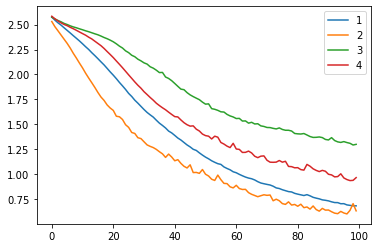

[{'acc': [0, 1, 2, 5, 6, 7, 14, 15, 16], 'gyro': [8, 9, 10, 17, 18, 19], 'mag': [11, 12, 13, 20, 21, 22]}, {'acc': [0, 1, 2, 5, 6, 7, 14, 15, 16]}, {'gyro': [8, 9, 10, 17, 18, 19]}, {'mag': [11, 12, 13, 20, 21, 22]}]


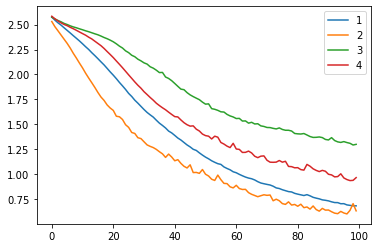

In [11]:
last_entry = 0

for round in range(rounds):
    # Global params for FL
    w_glob_tmp = None

    # Local params for FL
    w_loc_tmp = None

    # Count of encounters of each param
    w_loc_tmp_count = None
    if round > (1-lg_frac)*rounds:
        federatedLoc = False
    print_loss = []
    for client in range(n):
        w_glob_ret, w_local_ret, performance = clients[client].train(
            DataLoader(DatasetSplit(
                train_data, train_dict[client]), batch_size=32, shuffle=True)
        )

        print_loss.append(np.average(performance))

        if federatedGlob:
            # Global model, usually classifier
            # Always shared between all devices
            # All keys are the same on all clients
            if w_glob_tmp is None:
                w_glob_tmp = copy.deepcopy(w_glob_ret)
            else:
                for k in w_glob_ret:
                    w_glob_tmp[k] += w_glob_ret[k]

        if federatedLoc:
            # Local model, usually some encoder
            # Can have multiple modalities
            # Can be different between all clients

            if alpha_per_modality:
                factor = 1 if len(w_local_ret)/8 == 1 else len(w_local_ret)/8*alpha
            else:
                factor = 1 if len(w_local_ret)/8 == 1 else alpha

            if w_loc_tmp is None:
                w_loc_tmp = {}
                w_loc_tmp_count={}
            for k in w_local_ret.keys():
                if k not in w_loc_tmp:
                    w_loc_tmp[k] = factor*w_local_ret[k]
                    w_loc_tmp_count[k] = factor
                else:
                    w_loc_tmp[k] += factor*w_local_ret[k]
                    w_loc_tmp_count[k] += factor

        performance = clients[client].test(DataLoader(DatasetSplit(
            test_data, test_dict[client]), batch_size=32, shuffle=True))
        if test_performance[client] is None:
            test_performance[client] = copy.deepcopy(performance)
        else:
            test_performance[client] = np.hstack(
                (test_performance[client], performance))

    if train_performance is None:
        train_performance = np.array(print_loss).reshape(1, -1)
    else:
        train_performance = np.vstack(
            (train_performance, np.array(print_loss)))

    # get weighted average for global weights
    if federatedGlob:
        for k in w_glob_tmp.keys():
            w_glob_tmp[k] = torch.div(w_glob_tmp[k], n)
    if federatedLoc:
        for k in w_loc_tmp.keys():
            w_loc_tmp[k] = torch.div(w_loc_tmp[k], w_loc_tmp_count[k])

    # copy weights to each client based on mode
    if federatedGlob or federatedLoc:
        for client in range(n):
            clients[client].load_params(w_glob_tmp, w_loc_tmp)

    dsp.clear_output(wait=True)
    plt.clf()
    plt.plot(train_performance, label=[1, 2, 3, 4])
    plt.legend()
    dsp.display(plt.gcf())
    print(modalities)


In [12]:
save_path = main_folder+'/'+test_series_name+'/test_012'

if os.path.isdir(save_path) is False:
    os.mkdir(save_path, )
    torch.save(test_performance,f"{save_path}/test_data" )
    info_dict = {
        "Num of clients" : n,
        "Learning rate": learning_rate,
        "Federated Global" : federatedGlob,
        "Federated Local" : federatedLoc,
        "Batch Size" : batch_size,
        "Global rounds":rounds,
        "Local epochs": local_epochs,
        "Clients" : clients,
        "Modalities" : modalities,
        "Optimizer" : optimizer,
        "IID" : iid,
        "Temporal length" : temporal_len,
        "Transient dimension" : transient_dim,
        "Hidden dimensions" : hidden_dims,
        "Shared per class" : shard_per_class,
        "alpha" : alpha,
        "alpha_per_modality":alpha_per_modality
    }
    with open(f'{save_path}/test_info.txt', 'w') as f:
        f.write(info_dict.__repr__())

    for i in range(n):
        torch.save(clients[i].model.state_dict(), f"{save_path}/dev{i}_model")
else:
    print("test exists")

toaster.show_toast("Analysis Done")
notify.send('Analysis Done')


# Whats next?

4. Answer the same questions as IoT paper.
5. Fix algo
6. Try to evaluate the model on the unimodal client.
7. Calculate variance
8. Write mathematical explanation
9. generate graphs
10. Write explanation
